![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Machine Learning Methods </center>
## <center> Lecture 13 - Bayesian Regression </center>
### <center> Bayesian Optimization </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/MachineLearningMethod/13_BayesianRegression/MainGlobalBayesianOptimization.ipynb)

In [8]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})

### Define a kernel:

In [9]:
from scipy.spatial.distance import cdist

#-- Gaussian kernel:
def k(mX1, mX2, σ):
    mD = cdist(mX2, mX1)
    return np.exp(-mD**2 / (2 * σ**2))

In [10]:
def KernelBaysesianRegression(mX, vY, mX0, σ_ε, σ_w, k):
    λ     = (σ_ε / σ_w)**2
    N     = mX.shape[0]
    mK    = k(mX, mX)
    mInvK = np.linalg.inv(mK + λ * np.eye(N))
    mK0   = k(mX0, mX)
    
    vY0   = (mK0.T @ mInvK @ vY[:,None]).squeeze()
    vVar0 = 1 - np.sum((mK0.T @ mInvK) * mK0.T, axis=1) + σ_ε**2
    vσ0   = np.sqrt(np.maximum(vVar0, 0))
    
    return (vY0, vσ0)

###  Bayesian optimization:
$$\boldsymbol{x}_{t}\leftarrow\arg\underset{\boldsymbol{x}_{0}\in\mathcal{X}}{\min}\mu_{y_{0}}-\tau\sigma_{y_{0}}$$

### Boston data:

In [11]:
from sklearn.datasets import load_boston

mX, vY = load_boston(return_X_y=True)
mX.shape, vY.shape

((506, 13), (506,))

In [12]:
N   = mX.shape[0]
mX -= mX.mean(axis=0)
mX /= mX.std(axis=0)
vY -= vY.mean()
vY /= vY.std()

#### Bayesian optimization:

In [13]:
def BayesianOptimization(f, N, xx,  σ_ε=0.02, σ_w=2, σ=0.2, 𝜏=2):
    
    def GaussianKernel(mX1, mX2):
        mD = cdist(mX2, mX1)
        return np.exp(-mD**2 / (2 * σ**2))

    mX = np.full((N, xx.shape[1]), np.nan)
    vY = np.full(N,                np.nan)
    for ii in range(N):
        if ii == 0:
            idx = np.random.randint(xx.shape[0])
            
        mX[ii,:] = xx[idx,:]
        vY[ii]   = f(*mX[ii,:])

        mXi    = mX[:ii+1,:]
        vYi    = vY[:ii+1]
        yy, σσ = KernelBaysesianRegression(mXi, vYi, xx, σ_ε, σ_w, GaussianKernel)
        idx    = np.argmin(yy - 𝜏 * σσ)

    return mX, vY, yy, σσ
        

### (Advanced) exercise
* Modify the code and search both $\gamma$ and $\alpha$.
* Improve the $R^2$ score.

In [14]:
from sklearn.kernel_ridge    import KernelRidge
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import r2_score

def CrossValScore(ɣ, α, kFold=50):
    vHatY = cross_val_predict(KernelRidge(kernel='rbf', gamma=10**ɣ, alpha=10**α), mX, vY, cv=KFold(kFold, shuffle=True))
    return -r2_score(vY, vHatY)

In [15]:
CrossValScore(np.log10(0.06), np.log10(0.016))

-0.903269046997041

### Apply algorithm:

In [22]:
#-- Search interval:
vɣ     = np.linspace(-2, -1,      101)
vα     = np.linspace(-2.5, -1.25, 101)
mɣ, mα = np.meshgrid(vɣ, vα)

mP     = np.c_[mɣ.flatten(), mα.flatten()]
mP.shape

(10201, 2)

In [23]:
#-- Apply algorithm:
mXX, vYY, yy, vσ = BayesianOptimization(CrossValScore, 250, mP, σ_ε=0.01, σ_w=3, σ=0.3, 𝜏=20)

mXX.shape, vYY.shape, yy.shape, vσ.shape

((250, 2), (250,), (10201,), (10201,))

 #### Plot:

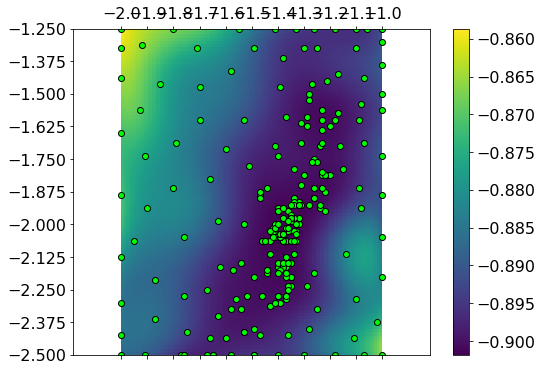

In [24]:
mYY = np.reshape(yy, mɣ.shape)
_, ax = plt.subplots(figsize=(8, 6))
# c = ax.matshow(mYY, extent=[vɣ.min(), vɣ.max(), vα.min(), vα.max()])
c = ax.matshow(mYY, extent=[vɣ.min(), vɣ.max(), vα.min(), vα.max()], origin='lower')
plt.scatter(mXX[:,0], mXX[:,1], c='lime', edgecolor='k')
ax.set_xticks(vɣ[::10])
ax.set_yticks(vα[::10])
plt.colorbar(c, ax=ax)
plt.axis('equal')
plt.show()

In [25]:
yIdx, xIdx = np.where(mYY == mYY.min())
vɣ[xIdx], vα[yIdx]

(array([-1.37]), array([-2.0125]))

In [26]:
mYY.min()

-0.9018188253820482

In [27]:
CrossValScore(vɣ[xIdx], vα[yIdx], kFold=N)

-0.9025238368885988